# Single-shot autofocus using deep learning
This notebook provides all code neccessary for and shows the production of all figures for the single-shot autofocus using deep learning

## Imports and preliminaries
Run these cells before going into any of the other sections

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from afutil import get_patch_metadata, read_or_calc_focal_planes, compile_deterministic_data,\
    feature_vector_generator_fn, MagellanWithAnnotation, plot_results, get_led_na
from defocusnetwork import DefocusNetwork
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

/home/henry/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The DataWrapper class wraps all the essential functionality needed for training single shot autofocus. By default, it reads Micro-Magellan datasets (with an added subclass to be able to store the results of intermediate computations in an HDF5 file), but this could be replaced with any data source so long as it provides the following methods and fields

In [2]:
class DataWrapper:

    def __init__(self, magellan):
        self.magellan = magellan

    #TODO: remember to change to float
    def read_ground_truth_image(self, position_index, z_index):
        """
        Read image in which focus quality can be measured form quality of image
        :param pos_index: index of xy position
        :param z_index: index of z slice (starting at 0)
        :param xy_slice: (cropped region of image)
        :return:
        """
        return self.magellan.read_image(channel_name='DPC_Bottom', pos_index=position_index, 
                        z_index=z_index + min(self.magellan.get_z_slices_at(position_index))).astype(np.float)

    def read_prediction_image(self, position_index, z_index, patch_index, split_k):
        """
        Read image used for single shot prediction (i.e. single LED image)
        :param pos_index: index of xy position
        :param z_index: index of z slice (starting at 0)
        :param split_k: number of crops along each dimension
        :param patch_index: index of the crop
        :return:
        """
        patch_size, patches_per_image = get_patch_metadata((self.get_image_width(),
                                                            self.get_image_height()), split_k)
        y_tile_index = patch_index // split_k
        x_tile_index = patch_index % split_k
        xy_slice = [[y_tile_index * patch_size, (y_tile_index + 1) * patch_size],
                    [x_tile_index * patch_size, (x_tile_index + 1) * patch_size]]
        image = self.magellan.read_image(channel_name='autofocus', pos_index=position_index, z_index=z_index +
                  min(self.magellan.get_z_slices_at(position_index))).astype(np.float)
        #crop
        return image[xy_slice[0][0]:xy_slice[0][1], xy_slice[1][0]:xy_slice[1][1]]
        
    def get_image_width(self):
        """
        :return: image width in pixels
        """
        return self.magellan.image_width

    def get_image_height(self):
        """
        :return: image height in pixels
        """
        return self.magellan.image_height

    def get_num_z_slices_at(self, position_index):
        """
        return number of z slices (i.e. focal planes) at the given XY position
        :param position_index:
        :return:
        """
        return len(self.magellan.get_z_slices_at(position_index))

    def get_pixel_size_z_um(self):
        """
        :return: distance in um between consecutive z slices
        """
        return self.magellan.pixel_size_z_um

    def get_num_xy_positions(self):
        """
        :return: total number of xy positons in data set
        """
        return self.magellan.get_num_xy_positions()

    def store_focal_plane(self, name, focal_position):
        """
        Store the computed focal plane as a string, float pair
        """
        self.magellan.write_annotation(name, focal_position)

    def read_focal_plane(self, name):
        """
        read a previously computed focal plane
        :param name: key corresponding to an xy position for whch focal plane has already been computed
        :return:
        """
        return self.magellan.read_annotation(name)

    def store_array(self, name, array):
        """
        Store a numpy array containing the design matrix for training the non-deterministic part of the network (i.e.
        after the Fourier transform) so that it can be retrained quickly without having to recompute
        :param name:
        :param array: (n examples) x (d feature length) numpy array
        """
        self.magellan.store_array(name, array)

    def read_array(self, name):
        """
        Read and return a previously computed array
        :param name:
        :return:
        """
        return self.magellan.read_array(name)

## Part 1: how well does a single-shot autofocus architecture generalize to different samples?
First we show how to do this with reasonably sized training data (~200GB) to facilitate being able to easily run or modify the code. Then we show a higher performing netwrok that is trained on much more data using the same workflow. Finally, we characterize the perfermance based on the amount of training data

### Load data and compute the ground truth focal planes as targets for training
The show_output flag will create a plot of the averaged high frequency content of the log power spectrum. If new data is substituted in, the maximum of the this plot should correspond to the correct focal plane

In [3]:
#parameters for the deterministic part of the network
#TODO: better explain what these mean
deterministic_params = {'non_led_width': 0.1, 'led_width': 0.6, 'tile_split_k': 2}

#load data
cell_data = DataWrapper(MagellanWithAnnotation(
    '/media/cosmosdata/henry/data/2018-9-27 Cells and histology af data/Neomounted cells 12x12 30um range 1um step_1'))
histology_data = DataWrapper(MagellanWithAnnotation(
    '/media/cosmosdata/henry/data/2018-9-27 Cells and histology af data/unstained path section 12x12 30um range 1um step_1'))

#load or compute target focal planes using 22 CPU cores to speed computation
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                    n_cores=22, show_output=True) for dataset in [cell_data, histology_data]}

Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading 

### Train network using cell data, compute validation on other cell data and tissue section data
The deterministic (i.e. Fourier Transform) beginning part of the network is precomputed and stored, so that it doesn't have to be recomputed on each training iteration

In [4]:
#split cell data into training and validation sets
num_pos = cell_data.get_num_xy_positions()
train_positions = list(range(int(num_pos * 0.9)))
validation_positions = list(range(max(train_positions) + 1, num_pos))
#use subset of histology dataset to save comput time
validation_positions_histology = list(range(len(validation_positions)))

#Compute or load already computed design matrices
train_features, train_targets = compile_deterministic_data([cell_data], [train_positions], focal_planes,
                                                           deterministic_params=deterministic_params)
validation_features_cells, validation_targets_cells = compile_deterministic_data([cell_data], [validation_positions],
                                                    focal_planes, deterministic_params=deterministic_params)
validation_features_section, validation_targets_section = compile_deterministic_data([histology_data], 
                        [validation_positions_histology], focal_planes, deterministic_params=deterministic_params)

Now use the precalculated features (i.e. the output of the deterministic part of the network) to train the subsequent layers

In [5]:
#make genenrator function for providing training examples and seperate validation generator for assessing its progress
#stop training once error on validation set stops decreasing
train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all', 
                                        split_k=deterministic_params['tile_split_k'])
val_generator_cells = feature_vector_generator_fn(validation_features_cells, validation_targets_cells, mode='all', 
                                        split_k=deterministic_params['tile_split_k'])
val_generator_section = feature_vector_generator_fn(validation_features_section, validation_targets_section, mode='all', 
                                        split_k=deterministic_params['tile_split_k'])

#feed in the dimensions of the cropped input so the inference network knows what to expect
#although the inference network is not explicitly used in this notebook, it is created so that the model tensforflow
#creates could later be used on real data
patch_size, patches_per_image = get_patch_metadata((cell_data.get_image_width(),
                                        cell_data.get_image_height()), deterministic_params['tile_split_k'])

#Create network and train it
defocus_prediction_network = DefocusNetwork(input_shape=train_features.shape[1], train_generator=train_generator,
                             val_generator=val_generator_cells, predict_input_shape=[patch_size, patch_size],
                             deterministic_params=deterministic_params, train_mode='train')

Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Building deterministic graph...
Building trainable graph...
INFO:tensorflow:Scale of 0 disables regularizer.
Training model...
Step 0, val loss: 17.716476440429688
Step 25, val loss: 17.680015563964844
Step 50, val loss: 17.621700286865234
Step 75, val loss: 17.526803970336914
Step 100, val loss: 17.360118865966797
Step 125, val loss: 16.963224411010742
Step 150, val loss: 16.38629913330078
Step 175, val loss: 15.654608726501465
Step 200, val loss: 15.171873092651367
Step 225, val loss: 14.795653343200684
Step 250, val loss: 14.607351303100586
Step 275, val loss: 14.451388359069824
Step 300, val loss: 14.385269165039062
Step 325, val loss: 14.299688339233398
Step 350, val loss: 14.240278244018555
Step 375, val loss: 14.151985168457031
Step 400, val loss: 14.080841064453125
Step 425, val loss: 13.95522689819336
Step 450, val loss: 13.8

Step 5100, val loss: 5.703653812408447
Step 5125, val loss: 5.815333843231201
Step 5150, val loss: 5.7963480949401855
Step 5175, val loss: 5.807919025421143
Step 5200, val loss: 5.7951860427856445
Step 5225, val loss: 5.804569721221924
Step 5250, val loss: 6.118287563323975
Step 5275, val loss: 5.75629186630249
Step 5300, val loss: 5.6812214851379395
Step 5325, val loss: 5.6521759033203125
Step 5350, val loss: 5.765652656555176
Step 5375, val loss: 5.783596992492676
Step 5400, val loss: 5.670804500579834
Step 5425, val loss: 5.733677387237549
Step 5450, val loss: 5.808472633361816
Step 5475, val loss: 5.718962669372559
Step 5500, val loss: 5.742464065551758
Step 5525, val loss: 5.691690444946289
Step 5550, val loss: 5.598552227020264
Step 5575, val loss: 5.618966579437256
Step 5600, val loss: 5.548978328704834
Step 5625, val loss: 5.601893424987793
Step 5650, val loss: 5.53181791305542
Step 5675, val loss: 5.647132396697998
Step 5700, val loss: 5.719666004180908
Step 5725, val loss: 5.

Step 10350, val loss: 5.932736396789551
Step 10375, val loss: 5.580185890197754
Step 10400, val loss: 5.57567834854126
Step 10425, val loss: 5.506195545196533
Step 10450, val loss: 5.576956748962402
Exporting model...
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./exported_model/saved_model.pb
Export complete


### Network performance on different parts of the same sample and different samples 

In [7]:
#run training set and both valdation sets through network to generate predictions
train_prediction_defocus, train_target_defocus = defocus_prediction_network.predict(train_generator)
val_prediction_defocus_cells, val_target_defocus_cells = defocus_prediction_network.predict(val_generator_cells)
test_prediction_defocus_histology, test_target_defocus_histoloy = defocus_prediction_network.predict(
    val_generator_section)

Visualize results on two validation sets: one of the same sample type the network was trained on (i.e. white blood cells) and another on a different sample type (tissue section)

Training data (cells) RMSE: 0.8546570400850302
Validation data (cells) RMSE: 4.595405879828533
Validation data (tissue section) RMSE: 16.21448319729901


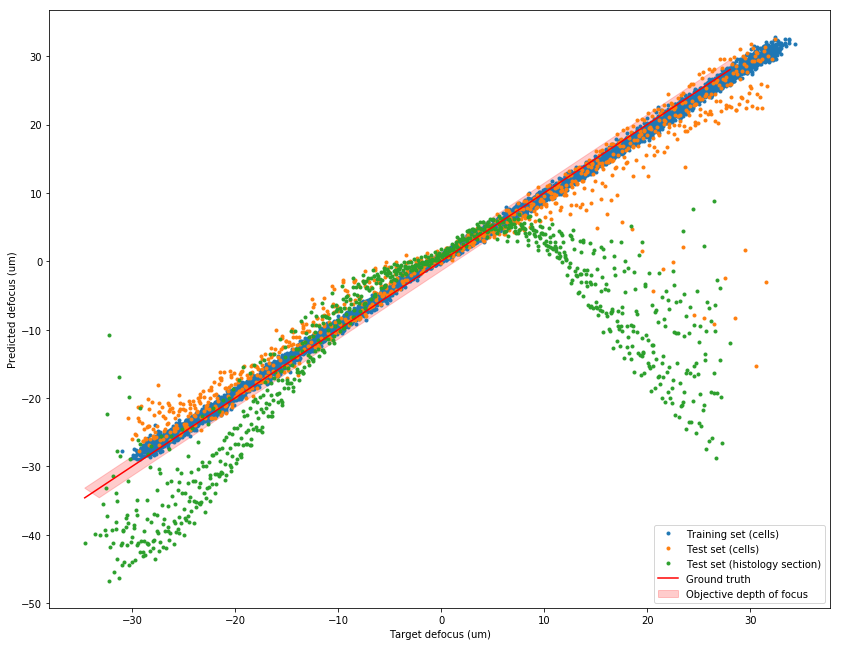

FileExistsError: [Errno 17] File exists: 'figures'

In [8]:
plt.figure(figsize=(14,11))
plot_results(train_pred_combined, train_target_combined)
plot_results(val_pred_combined_cells, val_target_combined_cells)
plot_results(val_pred_combined_section, val_target_combined_section, draw_rect=True)
plt.legend(['Training set (cells)',  'Test set (cells)', 'Test set (histology section)',
            'Ground truth', 'Objective depth of focus'])
print('Training data (cells) RMSE: {}'.format(
    np.sqrt(np.mean((train_pred_combined - train_target_combined) ** 2))))
print('Validation data (cells) RMSE: {}'.format(
    np.sqrt(np.mean((val_pred_combined_cells - val_target_combined_cells) ** 2))))
print('Validation data (tissue section) RMSE: {}'.format(
    np.sqrt(np.mean((val_pred_combined_section - val_target_combined_section) ** 2))))

plt.show()
os.mkdir('figures')
plt.savefig('figures/sample_generalization.svg')

# TODO load a bunch of cell data to compute a very good result
see how well this generalizes to cell and path data

# TODO: show that you can rescue performance on path slide by finetuning with a little path data
Does this damage performance on the orginal sample it was trained to predict?

# TODO: show performance given training dataset size

## Part 2: Illumination design
In this section we demonstrate why images with a single off-axis LED were chosen as the basis for autofocusing, by showing 1) single LED images perform better than multi-LED images and 2) the NA of a single LED affects network performance

The data used in this section consists of z-stacks, where at each z position, a series of images were taken with differnt LEDs with different NAs illuminating the sample. Multi-LED illuminations can be created computationally by adding the images from individual LED images, since different LEDs should be mutually incoherent and therefor their images will add in intensity on the sensor

In [3]:
class LEDDataWrapper(DataWrapper):
    
    def __init__(self, magellan, LED_indices):
        super().__init__(magellan)
        self.led_indices = LED_indices
        
    def read_prediction_image(self, position_index, z_index, patch_index, split_k):
        """
        Read image used for single shot prediction (i.e. single LED image)
        :param pos_index: index of xy position
        :param z_index: index of z slice (starting at 0)
        :param split_k: number of crops along each dimension
        :param patch_index: index of the crop
        :return:
        """
        patch_size, patches_per_image = get_patch_metadata((self.get_image_width(),
                                                            self.get_image_height()), split_k)
        y_tile_index = patch_index // split_k
        x_tile_index = patch_index % split_k
        xy_slice = [[y_tile_index * patch_size, (y_tile_index + 1) * patch_size],
                    [x_tile_index * patch_size, (x_tile_index + 1) * patch_size]]
        image = None
        for led_index in self.led_indices:
            new_image = self.magellan.read_image(channel_name='led_{}'.format(led_index), pos_index=position_index, 
                z_index=z_index + min(self.magellan.get_z_slices_at(position_index))).astype(np.float)
            if image is None:
                image = new_image
            else:
                image += new_image
            
        #crop
        return image[xy_slice[0][0]:xy_slice[0][1], xy_slice[1][0]:xy_slice[1][1]]
        
    
    #Ignore last xy posisiton in this dataset, since its acquisition was stopped in progress
    def get_num_xy_positions(self):
        return self.magellan.get_num_xy_positions() - 1

### Compute error on a validation set with networks trained with different 1, 2, and 3 LED patterns
First, load data, compute focal planes, and designate netowrk architecture, and which positions will be used for training and validation

In [4]:
#Illumination patterns by led index
# patterns = [[83], [119], [83, 119], [119, 120], [4, 188], [4, 119, 263]]
patterns = [[83]]


#create data wrappers for each single LED    
data_source = MagellanWithAnnotation(
    '/media/hugespace/henry/data/2018-9-26 Single LED autofocus data/Orthogonal lines LEDs 30um range 1um step_1/')
data_wrappers = [LEDDataWrapper(data_source, pattern) for pattern in patterns]

deterministic_params = {'non_led_width': 1.0, 'led_width': 1.0, 'tile_split_k': 2}
patch_size, patches_per_image = get_patch_metadata((data_wrappers[0].get_image_width(),
                        data_wrappers[0].get_image_height()), deterministic_params['tile_split_k'])
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                    n_cores=8, show_output=True) for dataset in data_wrappers}
#split cell data into training and validation sets
num_pos = data_wrappers[0].get_num_xy_positions()
train_positions = list(range(int(num_pos * 0.9)))
validation_positions = list(range(max(train_positions) + 1, num_pos))

Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading precomputed focal plane
Reading 

Train network for each illumination and measure the root mean square error on validation set

In [ ]:
def compute_validation_rmse(data_wrapper):
    """
    Function for training network and calculating root mean square error on 
    a validation set for different types of illumination
    :param pattern list of led indices to be used in illumination
    """
    print('loading features')
    train_features, train_targets = compile_deterministic_data([data_wrapper], [train_positions], 
                     focal_planes, deterministic_params=deterministic_params) 
    validation_features, validation_targets = compile_deterministic_data([data_wrapper], 
                    [validation_positions], focal_planes, deterministic_params=deterministic_params) 

    print('making generators')
    train_generator = feature_vector_generator_fn(train_features, train_targets, mode='all', 
                split_k=deterministic_params['tile_split_k'])
    validation_generator = feature_vector_generator_fn(validation_features, validation_targets, mode='all', 
                split_k=deterministic_params['tile_split_k']) 

    print('training network')
    #Create network and train it
    network = DefocusNetwork(input_shape=train_features.shape[1],train_generator=train_generator, 
        val_generator=validation_generator, predict_input_shape=[patch_size, patch_size],
        deterministic_params=deterministic_params, train_mode='train')

    print('predicting')
    #predict defocus on validation set
    predictions, targets = defocus_prediction_network.predict(validation_generator) 
    
#     #compute rmse for each set of predictions
#     return np.sqrt(np.mean((predictions - targets)** 2))

rmses = []
for data_wrapper, pattern in zip(data_wrappers, patterns):
    print('computing pattern {}'.format('_'.join(map(str,pattern))))
    #Compute or load already computed design matrices
    rmse = compute_validation_rmse(data_wrapper)
    rmses.append(rmse)

# TODO: make plot showing performance and color by type of label

### Same anallysis as above, but using single LEDs to quantify to effect of numerical aperture of illumination

In [7]:
#single led indices to use
leds = [[4], [12], [28], [48], [83], [119], [187], [263], [351]]
#create data wrappers for each single LED    
data_source = MagellanWithAnnotation(
    '/media/cosmosdata/henry/data/2018-9-26 Single LED autofocus data/Orthogonal lines LEDs 30um range 1um step_1')
data_wrappers = {led: LEDDataWrapper(data_source, [led]) for led in leds}
deterministic_params = {'non_led_width': 1.0, 'led_width': 1.0, 'tile_split_k': 2}
focal_planes = {dataset: read_or_calc_focal_planes(dataset, split_k=deterministic_params['tile_split_k'],
                    n_cores=22, show_output=True) for dataset in list(data_wrappers.values())}
rmses = []
numerical_apertures = []
for i, led in enumerate(leds):
    print('led {} of {}'.format(i, len(leds)))
    rmse = compute_validation_rmse(pattern)
    #compute rmse for each set of predictions
    rmses.append(np.sqrt(np.mean((predictions - targets))) ** 2)
    #get the numerical aperture of the led
    numerical_apertures.append(get_led_na(led[0]))

SyntaxError: invalid syntax (<ipython-input-7-536c70aec591>, line 43)


# TODO: plot NA vs validation RMSE

In [ ]:
plt.fig(figsize=(12,10)))
plt.plot(numerical_apertures, rmses, 'o')
plt.xlabel('Numerical aperture')
plt.ylabel('Validation RMSE')


# TODO: show throwing away real vs throwing away phase for network performance

# TODO: Show saliency map for what part of the image it pays attention to